## Install dependencies

In [1]:
!pip install nes-py > /dev/null
!pip install gym-super-mario-bros > /dev/null

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from abc import abstractmethod
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import pickle
from statistics import mean
from typing import List, Tuple, Union, Optional, NamedTuple
from tqdm import tqdm, trange
from tqdm.notebook import tqdm as tqdm_notebook

from nes_py.wrappers import JoypadSpace

from torch import nn
import torch

import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.smb_env import SuperMarioBrosEnv

## Definitions

In [ ]:
class Individual(NamedTuple('Individual', (
    ('weights', torch.Tensor),
    ))):
    def __copy__(self):
        return Individual(self.weights.copy())


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class Network(nn.Module):
    def __init__(self, layers: nn.Module) -> None:
        super(Network, self).__init__()
        self.layers = layers

    def forward(self, state: torch.Tensor) -> int:
        output = self.layers.forward(state.view(1, 3, 240, 256))
        return torch.argmax(output).item()

    def set_weights(self, weights: torch.Tensor) -> None:
        cpt = 0
        for param in self.parameters():
            tmp = reduce(operator.mul, param.size())
            # print(cpt, tmp)

            param.data.copy_(weights[cpt:cpt + tmp].view(param.size()).to(device))
            cpt += tmp

    def get_weights(self) -> Individual:
        return Individual(weights=torch.hstack([v.flatten() for v in self.parameters()]))


In [ ]:
class EvolutionaryAlgorithm:

    def __init__(
        self,
        env: JoypadSpace,
        network: Network,
        population_size: int,
        individual_len: int,
        eval_maps: int,
        eval_iters: int,
        max_iters: int,
    ) -> None:
        self.env = env
        self.population_size = population_size
        self.individual_len = individual_len
        self.eval_maps = eval_maps
        self.eval_iters = eval_iters
        self.max_iters = max_iters
        self.history_df = pd.DataFrame(columns=['iteration', 'min eval', 'mean eval', 'max eval'])
        self.network = network

        rom_mode = 'vanilla'  # The default one
        # Code from SuperMarioBrosRandomStagesEnv
        self.envs = []
        for world in range(1, 9):
            # append a new list to put this world's stages into
            self.envs.append([])
            # iterate over the stages in the world, i.e., {1, ..., 4}
            for stage in range(1, 5):
                # create the target as a tuple of the world and stage
                target = (world, stage)
                # create the environment with the given ROM mode
                env = SuperMarioBrosEnv(rom_mode=rom_mode, target=target)
                # add the environment to the stage list for this world
                self.envs[-1].append(env)
    
    @abstractmethod
    def random_population(self) -> List[Individual]:
        raise NotImplementedError()

    def evaluate(
        self, 
        individuals: List[Individual], 
        world_stages_tuples: Optional[List[Tuple[int, int]]]=None,
    ) -> List[int]:
        population_evals = np.zeros(len(individuals))

        if world_stages_tuples is None:
            world_idxs = np.random.choice(8, self.eval_maps, replace=False)
            stages_idxs = np.random.choice(4, self.eval_maps, replace=True)
            world_stages_tuples = list(zip(world_idxs, stages_idxs))

        for i, individual in tqdm_notebook(enumerate(individuals), desc='Evaluating', leave=False, total=len(individuals)):
            ind_evals = self._evaluate_individual(individual, world_stages_tuples)
            population_evals[i] = np.mean(ind_evals)
        
        return population_evals

    def _evaluate_individual(
        self, 
        individual: Individual, 
        world_stages_tuples: List[Tuple[int, int]],
        max_iters=None,    
    ) -> List[int]:
        if max_iters is None:
            max_iters = self.eval_iters
        
        self.network.set_weights(individual.weights)
        cumulative_rewards = []

        for world, stage in world_stages_tuples:
            # Hack for setting the enviroment to the selected world.
            self.env.env = self.envs[world][stage]
            # Need to be set before calling env.step, but wasn't as we didn't call env.reset directly.
            self.env._elapsed_steps = 0
            state = self.env.env.reset()

            current_cumulative_reward = 0

            for _ in range(max_iters):
                action = self.network.forward(torch.Tensor(state.copy()).to(device))

                state, reward, done, info = self.env.step(action)
                current_cumulative_reward += reward
                if done:
                    break
            
            cumulative_rewards.append(current_cumulative_reward)
        
        return cumulative_rewards

    @abstractmethod
    def mutate(self, parents: List[Individual]) -> List[Individual]:
        raise NotImplementedError()

    @abstractmethod
    def crossover(self, ind_1: Individual, ind_2: Individual) -> List[Individual]:
        raise NotImplementedError()

    @abstractmethod
    def selection(
        self,
        population: List[Individual],
        population_evals: List[int],
        children: List[Individual],
        children_evals: List[int]
    ) -> Tuple[List[Individual], List[int]]:
        raise NotImplementedError()

    @abstractmethod
    def parent_selection(self, population: List[Individual], evals: List[int]) -> List[Individual]:
        raise NotImplementedError()
    
    def run(self) -> None:
        
        pbar = tqdm_notebook(total=self.max_iters, desc='Training', position=0, leave=True)

        start_it = 0
        if os.path.exists(es_path):
            saved_cem = pickle.load(open(es_path, 'rb'))
            start_it = saved_cem['iteration']

            best, best_eval = saved_cem['best'], saved_cem['best_eval']

            self.history_df = saved_cem['history_df']

            population = saved_cem['population']

            pbar.update(start_it)
        else:
            best_eval = -1e5
            population = self.random_population()

        best_at_it = -1
        
        try:
            for it in range(start_it, self.max_iters):
                evals = self.evaluate(individuals=population)

                parents = self.parent_selection(population=population, evals=evals)
                
                children = self.mutate(parents)
                children_evals = self.evaluate(individuals=children)

                population, evals = self.selection(
                    population=population,
                    population_evals=evals,
                    children=children,
                    children_evals=children_evals,
                )
                best = population[np.argmax(evals)]

                self.history_df.loc[len(self.history_df)] = [it, min(evals), mean(evals), max(evals)]
                
                if max(evals) > best_eval:
                    best_at_it = it
                    best_eval = max(evals)
                
                to_write = {
                    'iteration': it,
                    'best': best,
                    'best_eval': best_eval,
                    'history_df': self.history_df,
                    'population': population
                }
                pickle.dump(to_write, open(es_path, 'w+b'), 
                            pickle.HIGHEST_PROTOCOL)

                pbar.desc = f'Training (evals: {min(evals)} | {mean(evals)} | {max(evals)}, best at: {best_at_it} it)'
                pbar.update(1)
        except KeyboardInterrupt:
            pass

        pbar.close()


In [ ]:
class ES(EvolutionaryAlgorithm):

    def __init__(
        self,
        env: JoypadSpace,
        network: Network,
        population_size: int,
        individual_len: int,
        eval_maps: int,
        eval_iters: int,
        max_iters: int,
        mutation_chance: float,
        min_eval_for_initial_population: float = -1e5
    ):
        super().__init__(env, network, population_size, individual_len, eval_maps, eval_iters, max_iters)
        self.mutation_chance = mutation_chance
        self.min_eval_for_initial_population = min_eval_for_initial_population

    def random_population(self) -> List[Individual]:
        population = [self._random_individual()
                      for _ in tqdm_notebook(range(self.population_size), desc='Creating random population', position=0, leave=True)]
        return population

    def _random_individual(self) -> Individual:
        while True:
            weights = torch.normal(torch.Tensor([0] * self.individual_len), torch.Tensor([1])).to(device)
            evals = []
            self.network.set_weights(weights)

            for _ in range(self.eval_maps):
                current_cumulative_reward = 0
                state = self.env.reset()

                for _ in range(self.eval_iters):
                    action = self.network.forward(torch.Tensor(state.copy()).to(device))
                    state, reward, done, info = self.env.step(action)
                    current_cumulative_reward += reward
                    if done:
                        break
                
                evals.append(current_cumulative_reward)
            if np.mean(evals) > self.min_eval_for_initial_population:
                break
        
        return Individual(weights=weights)

    def mutate(self, parents: List[Individual]) -> List[Individual]:
        ind_idxs, gene_idxs = torch.where(torch.rand(len(parents), self.individual_len) <= self.mutation_chance)
        rand_diff = torch.normal(torch.zeros(len(ind_idxs)), 5)

        for i, (ind_idx, gene_idx) in enumerate(torch.stack((ind_idxs, gene_idxs), axis=1)):
            parents[ind_idx].weights[gene_idx] += rand_diff[i]

        return parents
    
    def crossover(self, ind_1: Individual, ind_2: Individual) -> List[Individual]:
        new_weights_1 = ind_1.weights
        new_weights_2 = ind_2.weights

        selected_idxs = np.where(np.random.rand(self.individual_len) < 0.5)

        new_weights_1[selected_idxs] = ind_2.weights[selected_idxs]
        new_weights_2[selected_idxs] = ind_1.weights[selected_idxs]

        return [
            Individual(weights=new_weights_1),
            Individual(weights=new_weights_2),
        ]

    def selection(
        self,
        population: List[Individual],
        population_evals: List[int],
        children: List[Individual],
        children_evals: List[int],
    ) -> Tuple[List[Individual], List[int]]:
        evals = np.append(population_evals, children_evals)
        all_individuals = list(population + children)

        idxs = np.argsort(evals)[-self.population_size:]
        selected_individuals = [None] * self.population_size
        for i, idx in enumerate(idxs):
            selected_individuals[i] = all_individuals[idx]
        selected_evals = evals[idxs]

        return selected_individuals, selected_evals

    def parent_selection(self, population: List[Individual], evals: List[int]) -> List[Individual]:
        evals = np.array(evals)
        evals = np.maximum(1, evals)

        idxs = np.random.choice(
            a=self.population_size,
            size=self.population_size//2,
            replace=True,
            p=np.array(evals) / sum(evals),
        )

        selected_individuals = []

        for i, idx in enumerate(idxs):
            selected_individuals.append(population[idx])
        return selected_individuals

## Initialization

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0')

env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
network = Network(layers=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(46592, 7),
)).to(device)

## Experiments

In [ ]:
POPULATION_SIZE = 200
INDIVIDUAL_LEN = 75936+326144+7
MAX_ITERS = 100

agent = ES(
    env=env,
    network=network,
    population_size=POPULATION_SIZE,
    individual_len=INDIVIDUAL_LEN,
    eval_maps=4,
    eval_iters=500,
    max_iters=MAX_ITERS,
    mutation_chance=50 / INDIVIDUAL_LEN,
)

In [ ]:
%cd /content/drive/MyDrive/mario_bros_neuroevolution/

agent.run()

/content/drive/MyDrive/mario_bros_neuroevolution


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

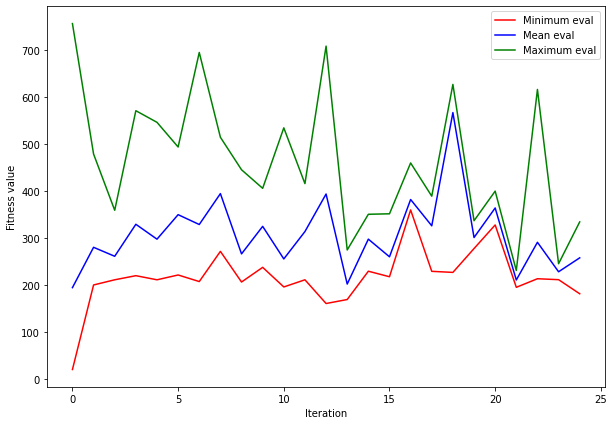

In [ ]:
df = agent.history_df
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(df[['min eval']][:25], c='r', label='Minimum eval')
plt.plot(df[['mean eval']][:25], c='b', label='Mean eval')
plt.plot(df[['max eval']][:25], c='g', label='Maximum eval')
plt.xlabel('Iteration')
plt.ylabel('Fitness value')
plt.legend()
plt.savefig('g1.png')